In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('dark_background')

['images', 'dimensions', 'positions', 'frame_segment_indexes', 'tracklets', 'frames', 'ids', 'encoding']
rgb8
(3829, 48, 48, 3)
(3829,)
(3829,)


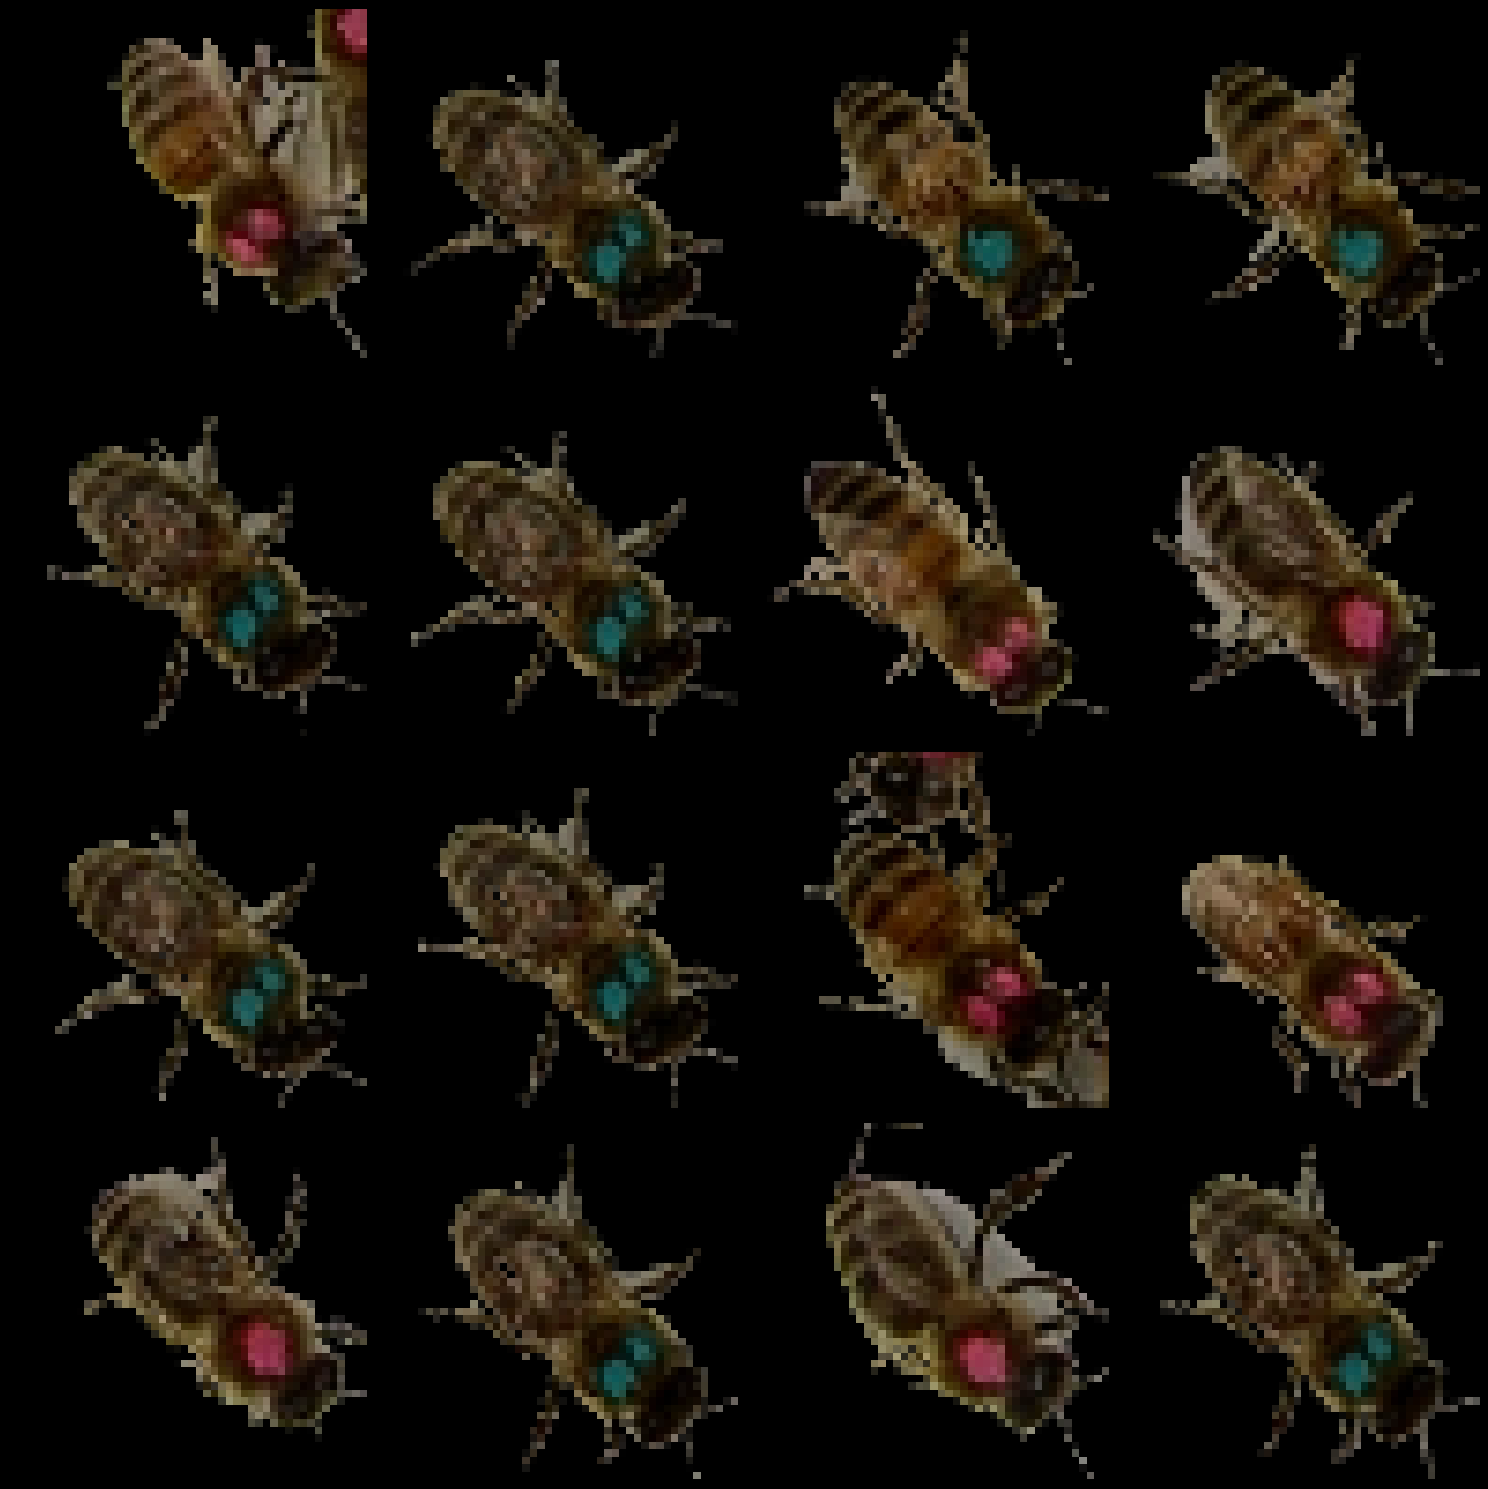

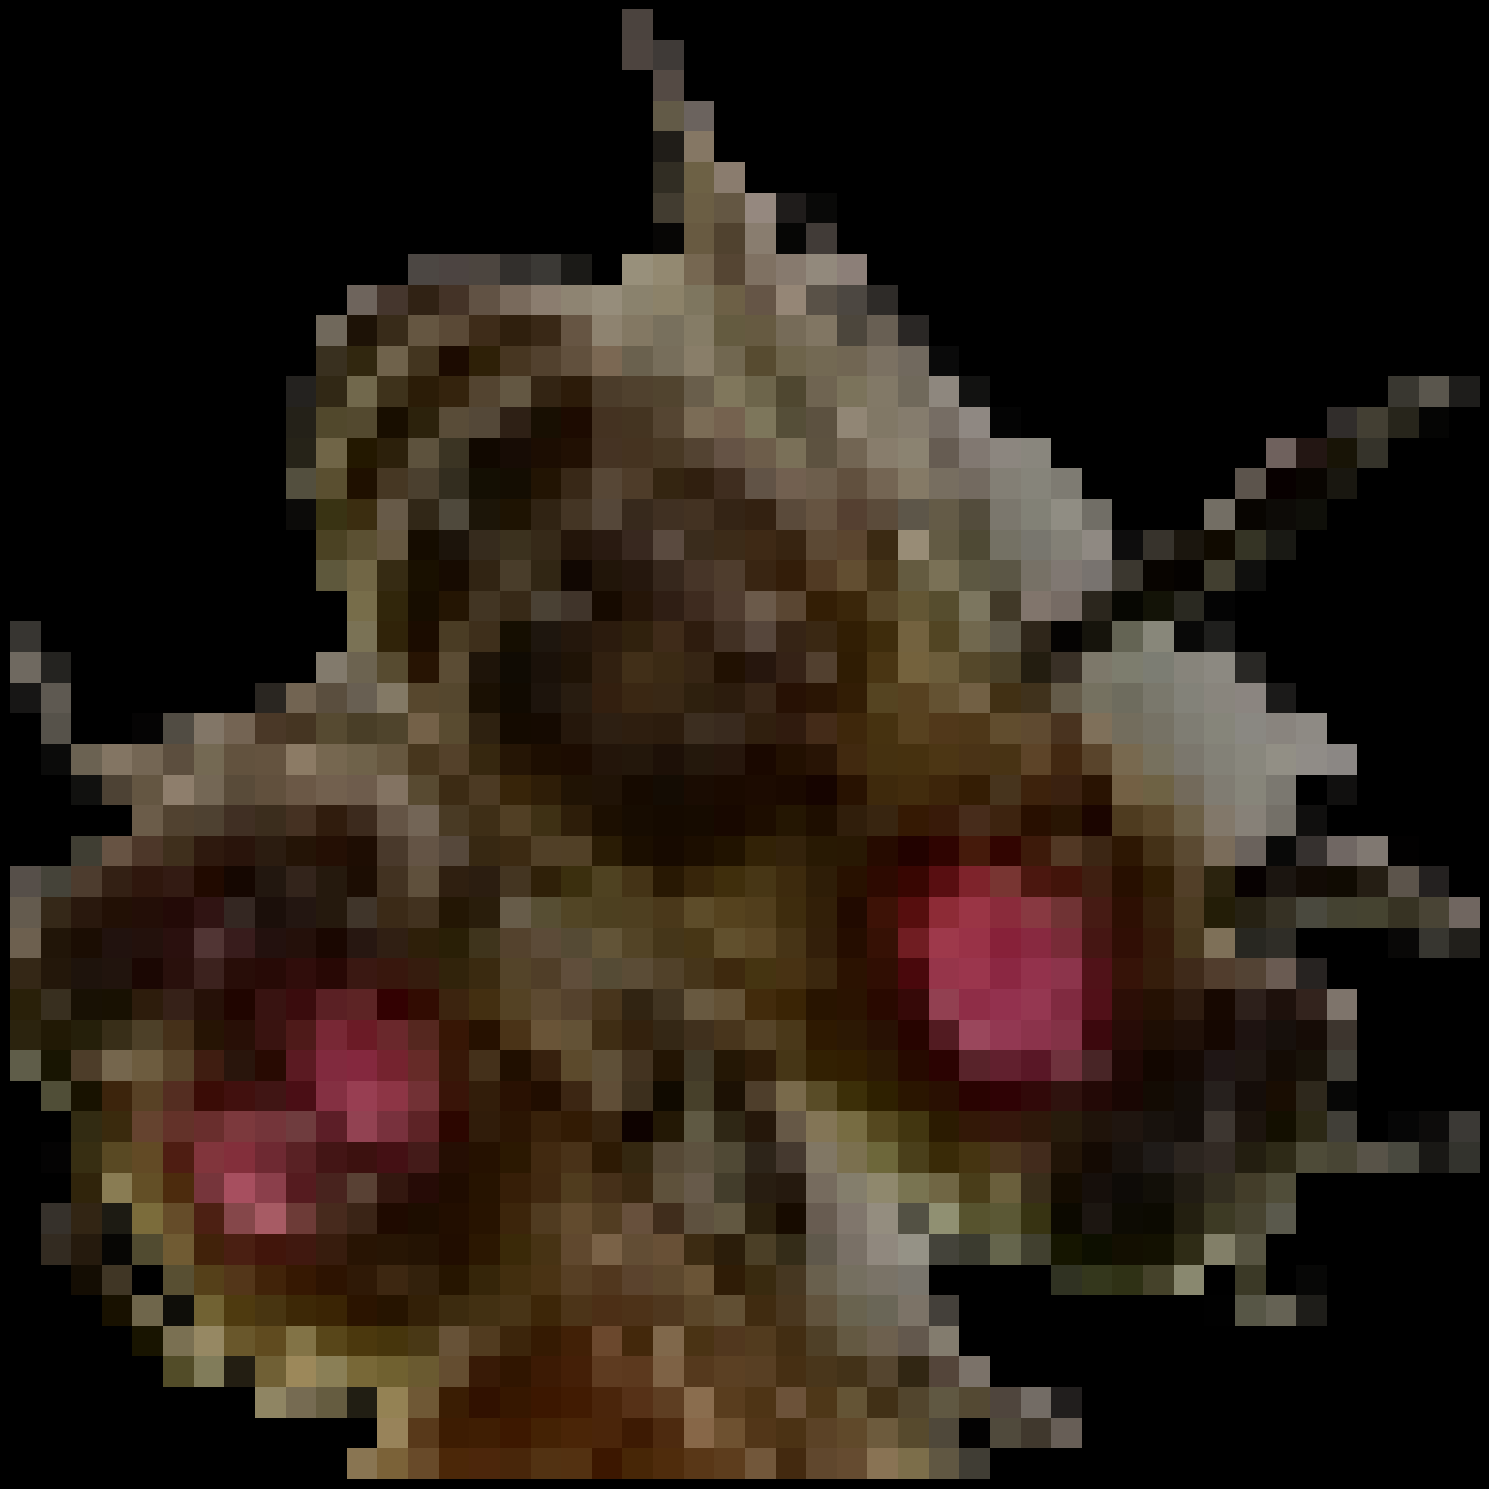

In [16]:
from math import sin


def images_r3g3b2_to_rgb(image):
    """
    Convert an image from 1 channel of r3g3b2 to 3 channels of rgb
    each bit is encoded by this:
    template<typename Vec>
    constexpr uint8_t vec_to_r3g3b2(const Vec& bgr) {
        return (uint8_t(bgr[0] / 64) << 6)
            | (uint8_t(bgr[1] / 32) << 3)
            | (uint8_t(bgr[2] / 32) << 0);
    }
    """
    assert image.shape[-1] == 1
    image = image.squeeze(-1)
    r = ((image >> 6) & 0b11) * 64
    g = ((image >> 3) & 0b111) * 32
    b = (image & 0b111) * 32
    return np.stack([r, g, b], axis=-1)

def single_image_r3g3b2_to_rgb(image):
    """
    Convert an image from 1 channel of r3g3b2 to 3 channels of rgb
    each bit
    """
    r = ((image >> 6) & 0b11) * 64
    g = ((image >> 3) & 0b111) * 32
    b = (image & 0b111) * 32
    return np.stack([r, g, b], axis=-1)

# if the images array is single dimensional, that means that
# the images are of different sizes, and the images are stored
# in a flat array. there is a second one called image_dimensions
# which is a (N, 3) array of the dimensions of each image.
# where N is the number of images and the 3 values are the
# height, width, and number of channels.
# the following function will return a wrapper that can access
# the images as if they were a 4D array.
def wrap_single_dimensional_images(images, image_dimensions, encoding):
    def get_image(idx):
        start = np.sum(image_dimensions[:idx, 0] * image_dimensions[:idx, 1] * image_dimensions[:idx, 2])
        end = start + image_dimensions[idx, 0] * image_dimensions[idx, 1] * image_dimensions[idx, 2]
        if encoding == "r3g3b2":
            dims = np.copy(image_dimensions[idx])
            dims[-1] = 3
            image = images[start:end].reshape(image_dimensions[idx])
            return single_image_r3g3b2_to_rgb(image).reshape(dims)
        return images[start:end].reshape(image_dimensions[idx])
    return get_image

with np.load("/Volumes/Public/work/bees/1920_rgb/data/hex_3_tracklet_images_single_part0.npz") as data:
    print(data.files)

    ## frame numbers indicating where each image is from in the video
    frames = data["frames"]

    ## decode the array of numbers in "encoding" to utf-8 string
    encoding = data["encoding"].tobytes().decode("utf-8")
    print(encoding)

    ## (N, 80, 80, 3) or (N) in case of single dimensional arrays, which
    ## are images of different sizes in a flat array.
    images = data["images"]

    positions = data["positions"]
    assert(positions.shape[0] == frames.shape[0]
           and positions.shape[1] == 2)

    print(images.shape)
    if images.shape[-1] == 1 and encoding == "r3g3b2":
        ## if the images are single dimensional, then we need to wrap the accessor
        ## to get the images as if they were a regular 4D array.
        images = images[..., 0]
        print("=>",images.shape)

    ## if the images are single dimensional, then we need to wrap the accessor
    ## to get the images as if they were a regular 4D array.
    if len(images.shape) == 1:
        image_dimensions = data["dimensions"]
        get_image = wrap_single_dimensional_images(images, image_dimensions, encoding)
    else:
        get_image = lambda idx: single_image_r3g3b2_to_rgb(images[idx]) if encoding == "r3g3b2" else images[idx]

    print(data["frames"].shape)
    print(data["ids"].shape)

    ### plot a grid of images
    fig, ax = plt.subplots(4, 4, figsize=(15, 15), dpi=100)
    indexes = np.random.randint(0, frames.shape[0], np.prod(ax.shape))
    for i, idx in enumerate(indexes):
        #print(i, idx, "frame =", data["frames"][idx], data["ids"][idx])
        image = get_image(idx)
        ax[i//ax.shape[0], i%ax.shape[0]].imshow(image, cmap="gray", vmin=0, vmax=255)
        ax[i//ax.shape[0], i%ax.shape[0]].axis("off")
    plt.tight_layout()
    plt.show()

    ### plot a single image
    fig, ax = plt.subplots(1, 1, figsize=(15, 15), dpi=100)
    idx = 0
    image = get_image(idx)
    ax.imshow(image, cmap="gray", vmin=0, vmax=255)
    ax.axis("off")
    plt.tight_layout()
    plt.show()
